<a href="https://colab.research.google.com/github/cindyy-chen/iss_movement/blob/main/google_colab_manipulating_ISS_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysis of the ISS Movement

## <font color="red">Required packages</font>

- country_converter
- Matplotlib
- NumPy
- Pandas
- Cartopy (might not be needed at the end)
- Shapely
- GeoPandas
- MovingPandas
- HoloViews
- hvplot

<font color="red">If using Google Colab, uncommment the line below</font>

In [1]:
!pip install country_converter
!pip install shapely
!pip install cartopy
!pip install geopandas
!pip install movingpandas
!pip install hvplot
!pip install holoviews
!pip install geoviews

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 616.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 34.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.2/77.2 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.2/535.2 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.0/557.0 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 23.5 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of panel to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.7/24.7 MB 51.8 MB/s eta 0:00:00
  Attempting uninstall: bokeh
    Found existing installation: bokeh 3.3.4
    Uninstalling bokeh-3.3.4:
      Successfully uninstalled bokeh-3.3.4
  Attempting uninstall: panel
    Found existing installation: 

---

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import os
from pathlib import Path
import datetime as dt

In [4]:
import country_converter as coco

In [5]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.cm as mcm

In [6]:
import cartopy
import cartopy.crs as ccrs

In [7]:
from shapely import geometry as shpgeom
from shapely import wkt as shpwkt

In [8]:
import numpy as np
import pandas as pd
import geopandas as gpd
import movingpandas as mpd

In [9]:
import holoviews as hv
import hvplot.pandas
import geoviews

In [10]:
#plot_defaults = {'linewidth':5, 'capstyle':'round', 'figsize':(9,3), 'legend':True}
hv.opts.defaults(hv.opts.Overlay(active_tools=['wheel_zoom'],
                                 frame_width=620, frame_height=400))
hvplot_defaults = {'tiles':None, 'cmap':'Viridis', 'colorbar':True}

In [11]:
mpd.show_versions()


MovingPandas 0.17.2

SYSTEM INFO
-----------
python     : 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
executable : /usr/bin/python3
machine    : Linux-6.1.58+-x86_64-with-glibc2.35

GEOS, GDAL, PROJ INFO
---------------------
GEOS       : None
GEOS lib   : None
GDAL       : 3.6.4
GDAL data dir: /usr/local/lib/python3.10/dist-packages/fiona/gdal_data
PROJ       : 9.3.0
PROJ data dir: /usr/local/lib/python3.10/dist-packages/pyproj/proj_dir/share/proj

PYTHON DEPENDENCIES
-------------------
geopandas  : 0.13.2
pandas     : 2.0.3
fiona      : 1.9.6
numpy      : 1.25.2
shapely    : 2.0.3
rtree      : 1.2.0
pyproj     : 3.6.1
matplotlib : 3.7.1
mapclassify: None
geopy      : 2.3.0
holoviews  : 1.17.1
hvplot     : 0.9.2
geoviews   : 1.12.0
stonesoup  : None


## Step 1: <font color="red">Read the CSV File</font>

In [12]:
file_name = "https://raw.githubusercontent.com/cindyy-chen/iss_movement/main/iss_timeseries_trajectories_20240303_104539.csv"

In [13]:
df = pd.read_csv(file_name)

In [14]:
df

t  latitude  longitude  land_flag  temperature  \
0     2024-03-03 10:45:39  -36.9477   -63.3776       True         22.4   
1     2024-03-03 10:45:45  -37.1914   -63.0247       True         21.7   
2     2024-03-03 10:45:52  -37.4542   -62.6395       True         21.1   
3     2024-03-03 10:45:58  -37.6752   -62.3114       True         19.9   
4     2024-03-03 10:46:03  -37.8953   -61.9813       True         20.8   
...                   ...       ...        ...        ...          ...   
3996  2024-03-03 17:00:09  -43.6702  -145.9861      False         17.0   
3997  2024-03-03 17:00:14  -43.8520  -145.5860      False         16.8   
3998  2024-03-03 17:00:20  -44.0321  -145.1835      False         16.5   
3999  2024-03-03 17:00:26  -44.2268  -144.7414      False         16.2   
4000  2024-03-03 17:00:31  -44.4036  -144.3334      False         15.9   

      windspeed  traj_id           country  
0           5.7        0         Argentina  
1           3.1        0         Argentina  
2           3.7        0         Argentina  
3          10.2        0         Argentina  
4          11.7        0         Argentina  
...         ...      ...               ...  
3996       39.9        4  French Polynesia  
3997       40.4        4  French Polynesia  
3998       43.6        4  French Polynesia  
3999       44.1        4  French Polynesia  
4000       42.6        4  French Polynesia  

[4001 rows x 8 columns]

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4001 entries, 0 to 4000
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   t            4001 non-null   object 
 1   latitude     4001 non-null   float64
 2   longitude    4001 non-null   float64
 3   land_flag    4001 non-null   bool   
 4   temperature  4001 non-null   float64
 5   windspeed    4001 non-null   float64
 6   traj_id      4001 non-null   int64  
 7   country      4001 non-null   object 
dtypes: bool(1), float64(4), int64(1), object(2)
memory usage: 222.8+ KB


Note that the column `t` has string as data type. We want it to be a datetime object.

## Step 2: <font color="red">Perform Conversions</font>

#### Convert the `t` column into a datetime object

In [16]:
df['t'] = pd.to_datetime(df['t'], format='%Y-%m-%d %H:%M:%S')

Make the `t` column as index

In [17]:
#df.set_index('t', inplace=True)

In [18]:
df.head(4)

t  latitude  longitude  land_flag  temperature  windspeed  \
0 2024-03-03 10:45:39  -36.9477   -63.3776       True         22.4        5.7   
1 2024-03-03 10:45:45  -37.1914   -63.0247       True         21.7        3.1   
2 2024-03-03 10:45:52  -37.4542   -62.6395       True         21.1        3.7   
3 2024-03-03 10:45:58  -37.6752   -62.3114       True         19.9       10.2   

   traj_id    country  
0        0  Argentina  
1        0  Argentina  
2        0  Argentina  
3        0  Argentina

#### Count the number of locations that are on land:
- `land_flag` is `True` for land and `False` otherwise (ocean).

In [19]:
df.land_flag.sum()

1128

#### Convert the positions (latitude and longitude) into `Shapely` POINT objects:
- Add a `geometry` column

In [20]:
df['geometry'] = [shpgeom.Point(xy) for xy in zip(df['longitude'], df['latitude'])]
df

t  latitude  longitude  land_flag  temperature  \
0    2024-03-03 10:45:39  -36.9477   -63.3776       True         22.4   
1    2024-03-03 10:45:45  -37.1914   -63.0247       True         21.7   
2    2024-03-03 10:45:52  -37.4542   -62.6395       True         21.1   
3    2024-03-03 10:45:58  -37.6752   -62.3114       True         19.9   
4    2024-03-03 10:46:03  -37.8953   -61.9813       True         20.8   
...                  ...       ...        ...        ...          ...   
3996 2024-03-03 17:00:09  -43.6702  -145.9861      False         17.0   
3997 2024-03-03 17:00:14  -43.8520  -145.5860      False         16.8   
3998 2024-03-03 17:00:20  -44.0321  -145.1835      False         16.5   
3999 2024-03-03 17:00:26  -44.2268  -144.7414      False         16.2   
4000 2024-03-03 17:00:31  -44.4036  -144.3334      False         15.9   

      windspeed  traj_id           country                    geometry  
0           5.7        0         Argentina   POINT (-63.3776 -36.9477)  
1           3.1        0         Argentina   POINT (-63.0247 -37.1914)  
2           3.7        0         Argentina   POINT (-62.6395 -37.4542)  
3          10.2        0         Argentina   POINT (-62.3114 -37.6752)  
4          11.7        0         Argentina   POINT (-61.9813 -37.8953)  
...         ...      ...               ...                         ...  
3996       39.9        4  French Polynesia  POINT (-145.9861 -43.6702)  
3997       40.4        4  French Polynesia    POINT (-145.586 -43.852)  
3998       43.6        4  French Polynesia  POINT (-145.1835 -44.0321)  
3999       44.1        4  French Polynesia  POINT (-144.7414 -44.2268)  
4000       42.6        4  French Polynesia  POINT (-144.3334 -44.4036)  

[4001 rows x 9 columns]

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4001 entries, 0 to 4000
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   t            4001 non-null   datetime64[ns]
 1   latitude     4001 non-null   float64       
 2   longitude    4001 non-null   float64       
 3   land_flag    4001 non-null   bool          
 4   temperature  4001 non-null   float64       
 5   windspeed    4001 non-null   float64       
 6   traj_id      4001 non-null   int64         
 7   country      4001 non-null   object        
 8   geometry     4001 non-null   object        
dtypes: bool(1), datetime64[ns](1), float64(4), int64(1), object(2)
memory usage: 254.1+ KB


In [22]:
df.head(4)

t  latitude  longitude  land_flag  temperature  windspeed  \
0 2024-03-03 10:45:39  -36.9477   -63.3776       True         22.4        5.7   
1 2024-03-03 10:45:45  -37.1914   -63.0247       True         21.7        3.1   
2 2024-03-03 10:45:52  -37.4542   -62.6395       True         21.1        3.7   
3 2024-03-03 10:45:58  -37.6752   -62.3114       True         19.9       10.2   

   traj_id    country                   geometry  
0        0  Argentina  POINT (-63.3776 -36.9477)  
1        0  Argentina  POINT (-63.0247 -37.1914)  
2        0  Argentina  POINT (-62.6395 -37.4542)  
3        0  Argentina  POINT (-62.3114 -37.6752)

## Step 3: <font color="red">Manipulation with GeoPandas</font>

#### Create a GeoDataFrame

In [23]:
iss_gdf = gpd.GeoDataFrame(df, geometry="geometry")
iss_gdf

t  latitude  longitude  land_flag  temperature  \
0    2024-03-03 10:45:39  -36.9477   -63.3776       True         22.4   
1    2024-03-03 10:45:45  -37.1914   -63.0247       True         21.7   
2    2024-03-03 10:45:52  -37.4542   -62.6395       True         21.1   
3    2024-03-03 10:45:58  -37.6752   -62.3114       True         19.9   
4    2024-03-03 10:46:03  -37.8953   -61.9813       True         20.8   
...                  ...       ...        ...        ...          ...   
3996 2024-03-03 17:00:09  -43.6702  -145.9861      False         17.0   
3997 2024-03-03 17:00:14  -43.8520  -145.5860      False         16.8   
3998 2024-03-03 17:00:20  -44.0321  -145.1835      False         16.5   
3999 2024-03-03 17:00:26  -44.2268  -144.7414      False         16.2   
4000 2024-03-03 17:00:31  -44.4036  -144.3334      False         15.9   

      windspeed  traj_id           country                      geometry  
0           5.7        0         Argentina   POINT (-63.37760 -36.94770)  
1           3.1        0         Argentina   POINT (-63.02470 -37.19140)  
2           3.7        0         Argentina   POINT (-62.63950 -37.45420)  
3          10.2        0         Argentina   POINT (-62.31140 -37.67520)  
4          11.7        0         Argentina   POINT (-61.98130 -37.89530)  
...         ...      ...               ...                           ...  
3996       39.9        4  French Polynesia  POINT (-145.98610 -43.67020)  
3997       40.4        4  French Polynesia  POINT (-145.58600 -43.85200)  
3998       43.6        4  French Polynesia  POINT (-145.18350 -44.03210)  
3999       44.1        4  French Polynesia  POINT (-144.74140 -44.22680)  
4000       42.6        4  French Polynesia  POINT (-144.33340 -44.40360)  

[4001 rows x 9 columns]

### <font color="green">Preparing the data</font>

#### Split the paths into two groups: land and ocean

In [24]:
iss_gdf_land = iss_gdf[iss_gdf.land_flag==True]
iss_gdf_ocean = iss_gdf[iss_gdf.land_flag==False]

#### Get the names and acronyms of overpassed countries

In [25]:
country_names = list(iss_gdf_land.country.unique())

In [26]:
out_format = "ISO3"
country_acronyms = [coco.convert(x, to=out_format, not_found=None) for x in country_names]

#### Get the GeoDataFrame of all the countries of the world

This is obtained through the Natural Earth Database background image

In [27]:
gdf_world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

#### From the `gdf_world` GeoDataFrame, extract the overpassed countries only

In [28]:
mask = gdf_world['iso_a3'].isin(country_acronyms)
gdf_country_overpass = gdf_world[mask]
#gdf_country_overpass

#### Compute the centroids of the overpassed countries

In [29]:
gdf_country_overpass['centroid'] = gdf_country_overpass.centroid
#gdf_country_overpass

### <font color="green">Create maps</font>

#### Quick plot of the paths using `Cartopy`

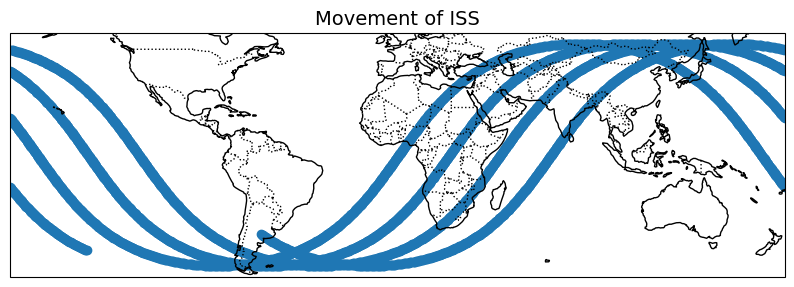

In [30]:
fig, ax = plt.subplots(1, 1, subplot_kw={'projection': ccrs.PlateCarree()})
fig.set_size_inches(10, 10)
iss_gdf.plot(
    ax=ax
)
ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
ax.coastlines()
plt.title('Movement of ISS', fontsize = 14);
plt.savefig("fig_iss_paths_no_countries")

#### Plot by country crossed using Cartopy

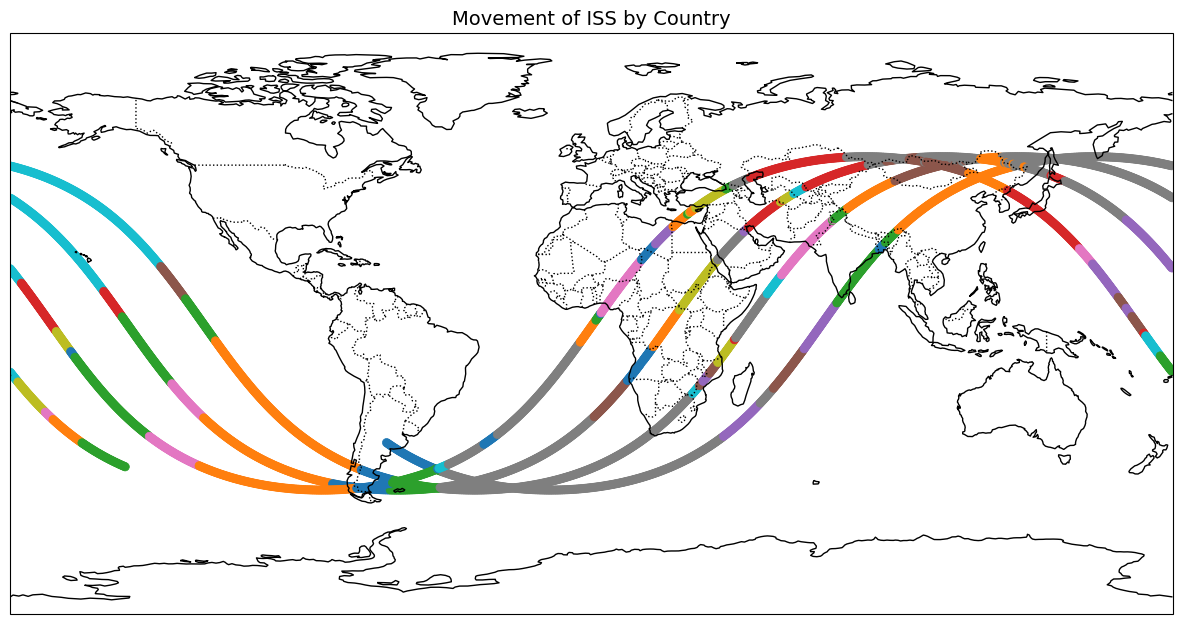

In [31]:
fig, ax = plt.subplots(1, 1, subplot_kw={'projection': ccrs.PlateCarree()})
fig.set_size_inches(15, 10)
iss_gdf.plot(column="country", ax=ax, linewidth=0.5)

ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
ax.coastlines()
ax.set_global()
plt.title('Movement of ISS by Country', fontsize = 14);

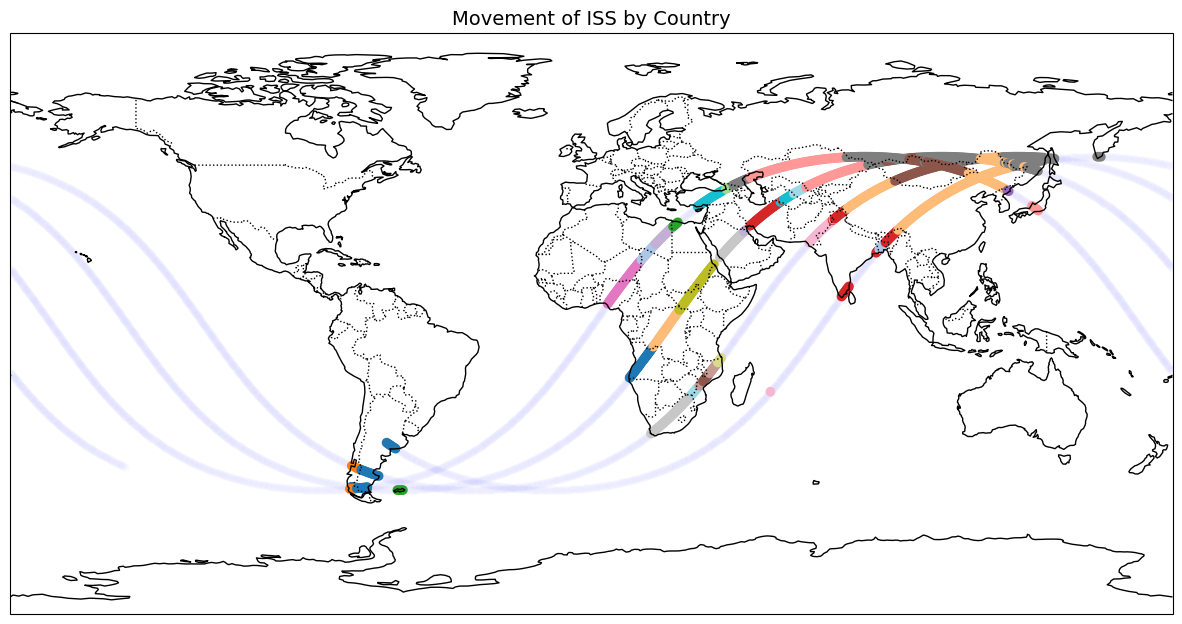

In [32]:
fig, ax = plt.subplots(1, 1, subplot_kw={'projection': ccrs.PlateCarree()})
fig.set_size_inches(15, 10)

iss_gdf_ocean.plot(ax=ax, color="blue", linewidth=0.05, alpha=0.015)
iss_gdf_land.plot(column="country",  ax=ax, cmap=mcm.get_cmap("tab20"))

ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
ax.coastlines()
ax.set_global()
plt.title('Movement of ISS by Country', fontsize = 14);

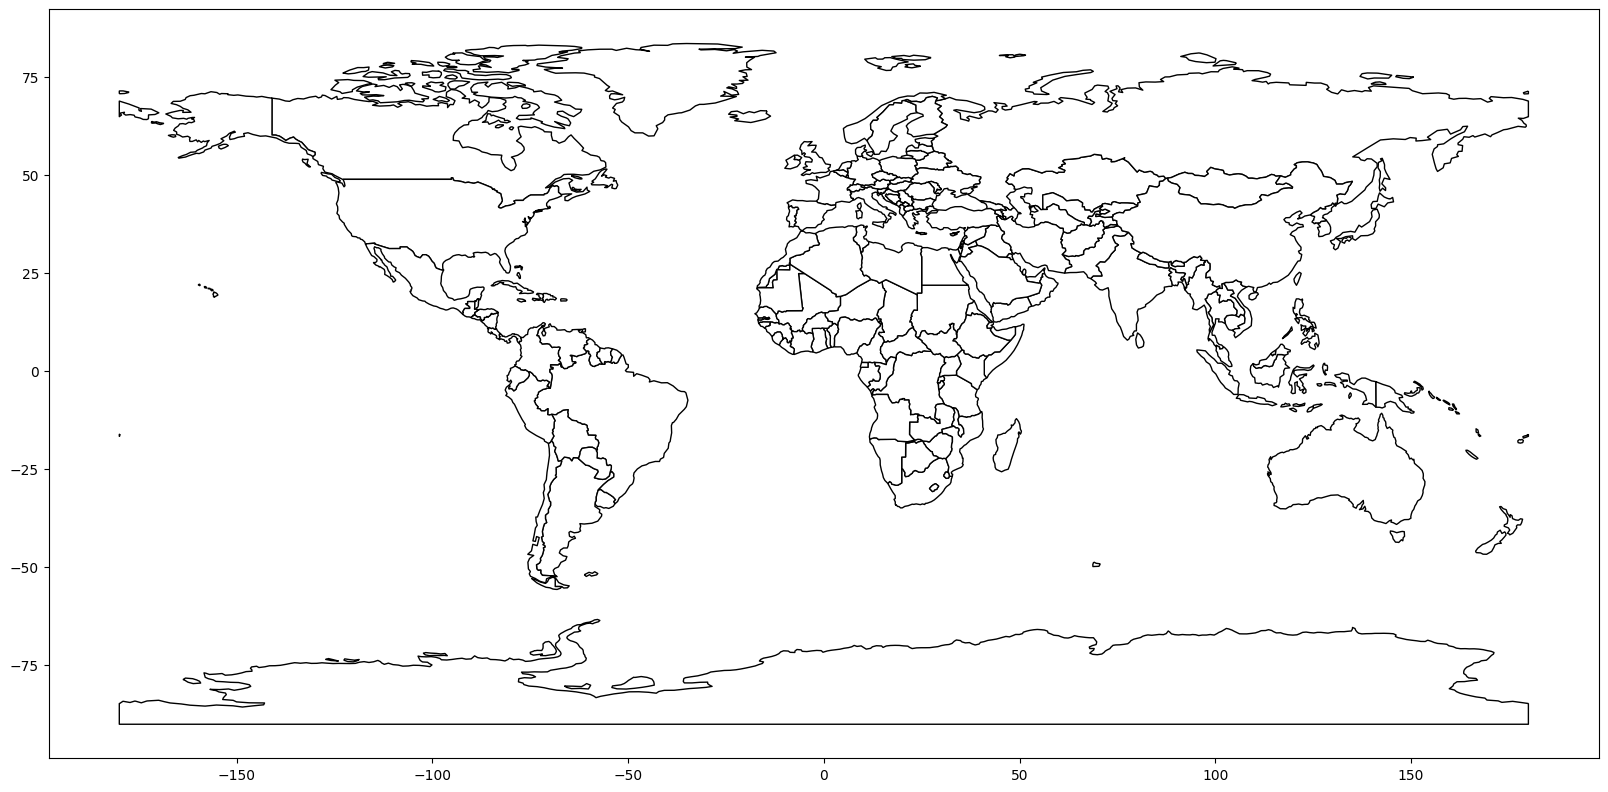

In [33]:
fig, ax = plt.subplots(1, figsize=(20,10))
base = gdf_world.plot(ax=ax, color='white', edgecolor='black',)

#### Map the globe and write the acronyms of overpassed countries

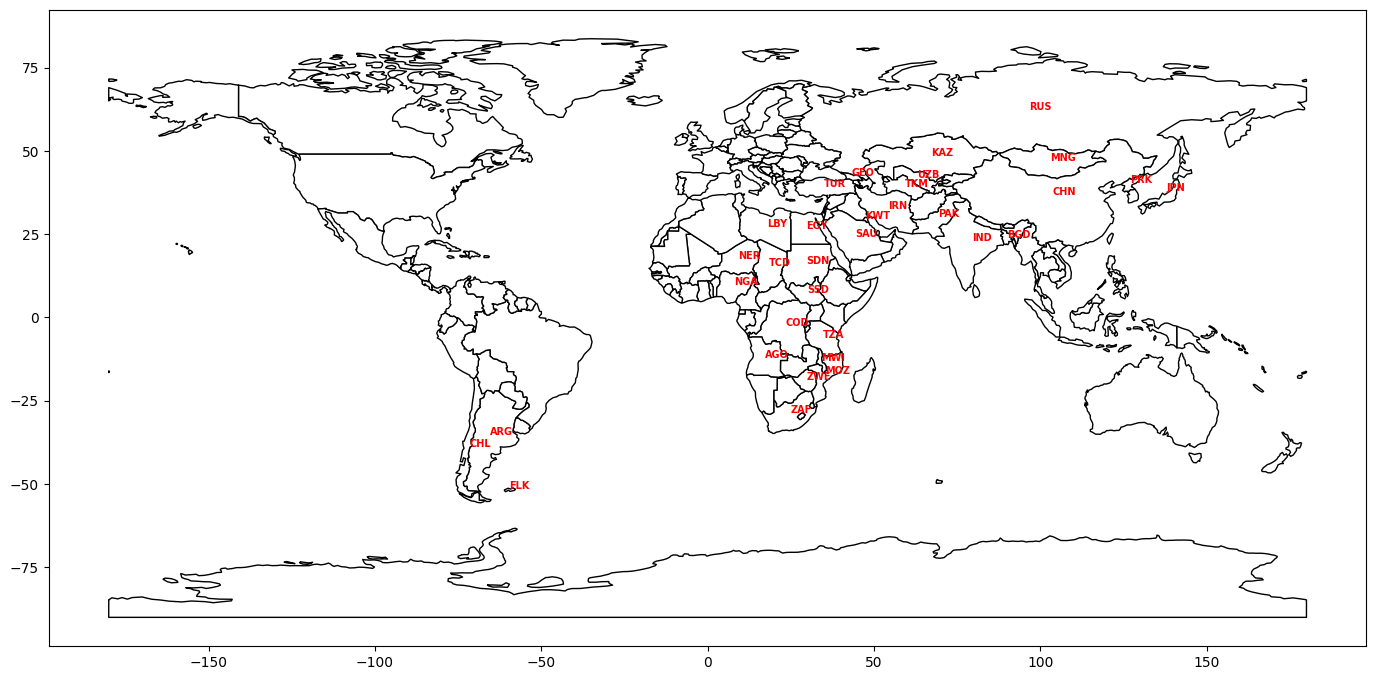

In [34]:
fig, ax = plt.subplots(1,1,figsize=(17,14))
base = gdf_world.plot(ax=ax, color='white', edgecolor='black',)
for x, y, label in zip(gdf_country_overpass.centroid.x, gdf_country_overpass.centroid.y, gdf_country_overpass.iso_a3):
    base.annotate(label, xy=(x, y), xytext=(-0.25, 0.5),
                  color="red",
                  weight="bold",
                  size="7",
                  textcoords="offset points")

#### Map the globe, plot the paths and write the acronyms of overpassed countries

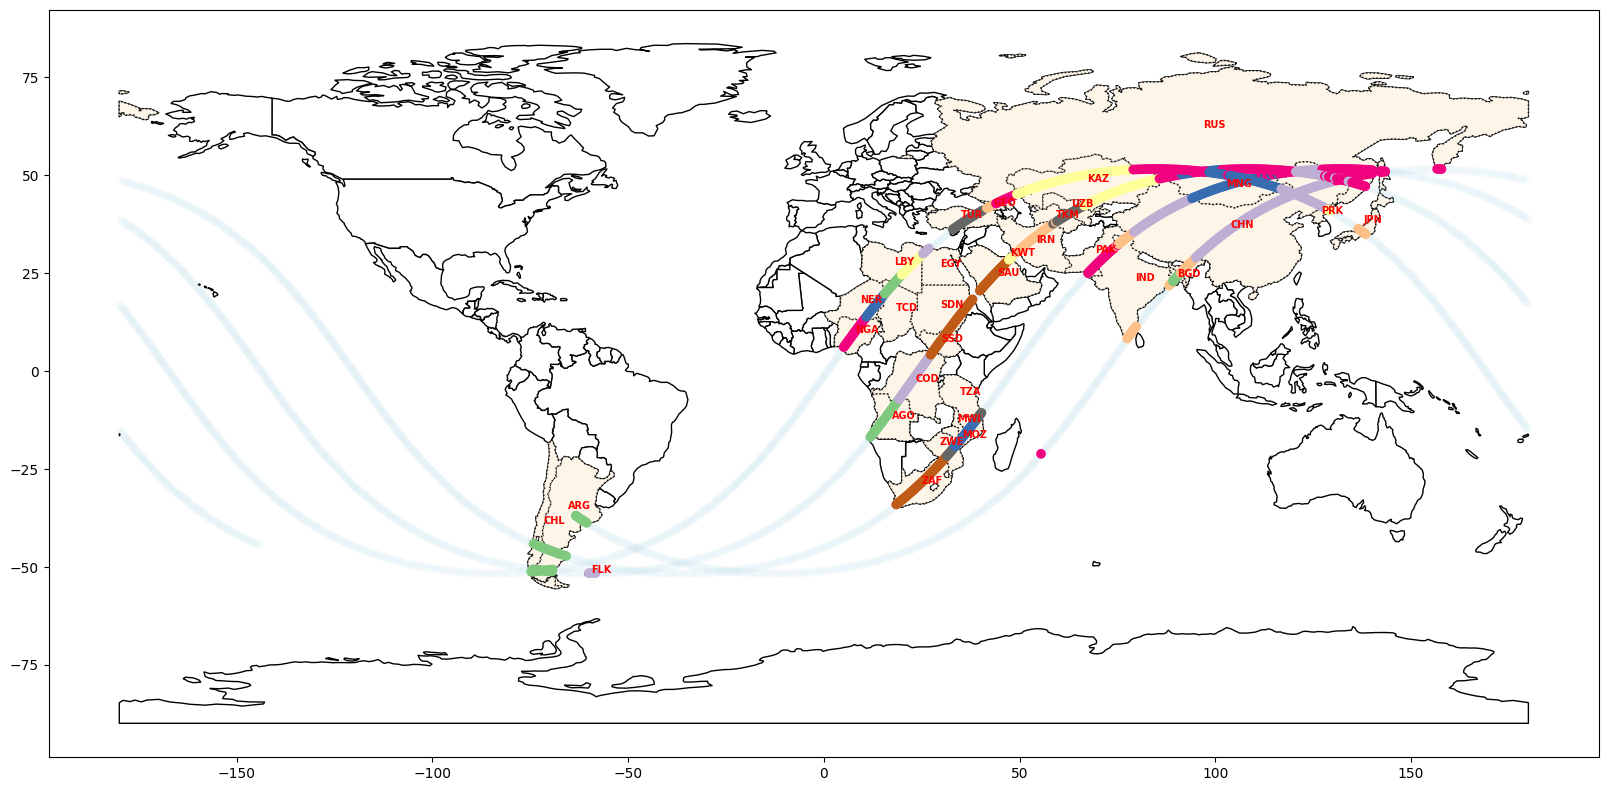

In [35]:
fig, ax = plt.subplots(1, figsize=(20,10))
# base = gdf_world.plot(ax=ax, color='white', edgecolor='black',)
gdf_world.plot(ax=ax, color='white', edgecolor='black')
gdf_country_overpass.plot(color='oldlace', ax=ax, edgecolor='black', alpha=0.90, linestyle=':')

iss_gdf_ocean.plot(ax=ax, color="skyblue", linewidth=0.05, alpha=0.035)
iss_gdf_land.plot(column="country",  ax=ax, cmap=mcm.get_cmap("Accent"))


for x, y, label in zip(gdf_country_overpass.centroid.x, gdf_country_overpass.centroid.y, gdf_country_overpass.iso_a3):
    ax.annotate(label, xy=(x, y), xytext=(-0.25, 0.5),
                  color="red",
                  weight="bold",
                  size="7",
                  textcoords="offset points")

plt.savefig("fig_iss_paths_all_countries")

In [36]:
!ls

fig_iss_paths_all_countries.png  fig_iss_paths_no_countries.png  sample_data


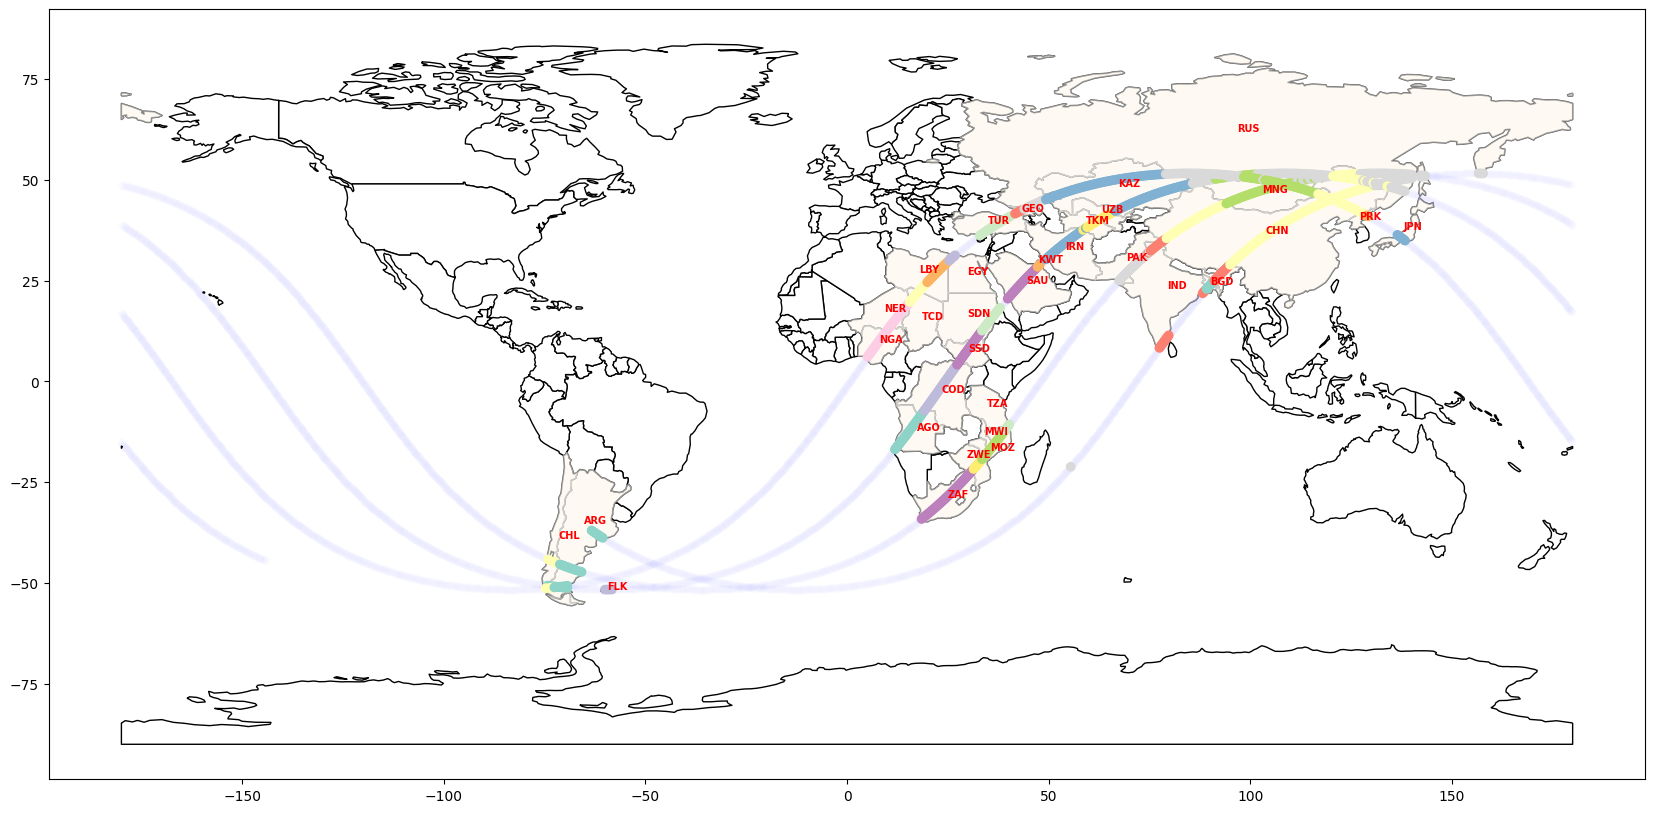

In [59]:
# make coutry acrynym blue and white
# make ocean line thinner

fig, ax = plt.subplots(1, figsize=(25,10))
base = gdf_world.plot(ax=ax, color='white', edgecolor='black',)
gdf_country_overpass.plot(color='oldlace', ax=base, edgecolor='white', alpha=0.45)

iss_gdf_ocean.plot(ax=ax, color="blue", linewidth=0.05, alpha=0.015)
iss_gdf_land.plot(column="country",  ax=ax, cmap=mcm.get_cmap("Set3"))

for x, y, label in zip(gdf_country_overpass.centroid.x, gdf_country_overpass.centroid.y, gdf_country_overpass.iso_a3):
    base.annotate(label, xy=(x, y), xytext=(-0.25, 0.5),
                  color="red",
                  weight="bold",
                  size="7",
                  textcoords="offset points");
plt.savefig("fig_iss_paths_all_countries1")

In [62]:
print("\033[104m\033[97mThis is white text on a darker blue background\033[0m")


This is white text on a darker blue background


# Step 4: Manipulation with MovingPandas

#### Create the MovingPandas trajectories

Create a GeoDataFram by specifying the Coordinate Reference System (CRS)

In [38]:
gdf_path = gpd.GeoDataFrame(df, crs={'init': 'epsg:4326'})

Create the MovingPandas trajectories

In [39]:
iss_trajc = mpd.TrajectoryCollection(gdf_path,
                                 x = "longitude", y="latitude",
                                 traj_id_col="traj_id", t="t")

#### Quick plots

Simple plot with all the trajectories

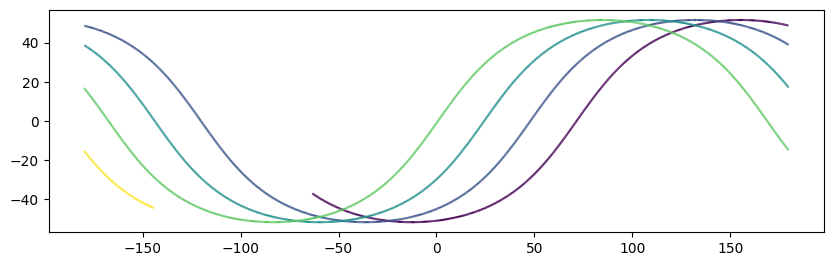

In [40]:
iss_trajc.plot(column='traj_id', figsize=(10,20));

Determine the number of trajectories

In [41]:
num_trajs = len(iss_trajc.trajectories)
print(f"Number of trajectories: {num_trajs}")

Number of trajectories: 5


Plot the individual trajectories

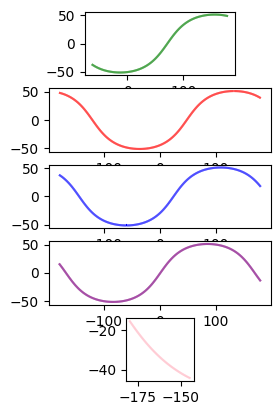

In [42]:
colors = ["green", "red", "blue", "purple", "pink"]
fig, ax = plt.subplots(num_trajs, 1)
for i in range(num_trajs):
    iss_trajc.trajectories[i].plot(ax=ax[i], color=colors[i])

#### Include Weather Data

<Axes: >

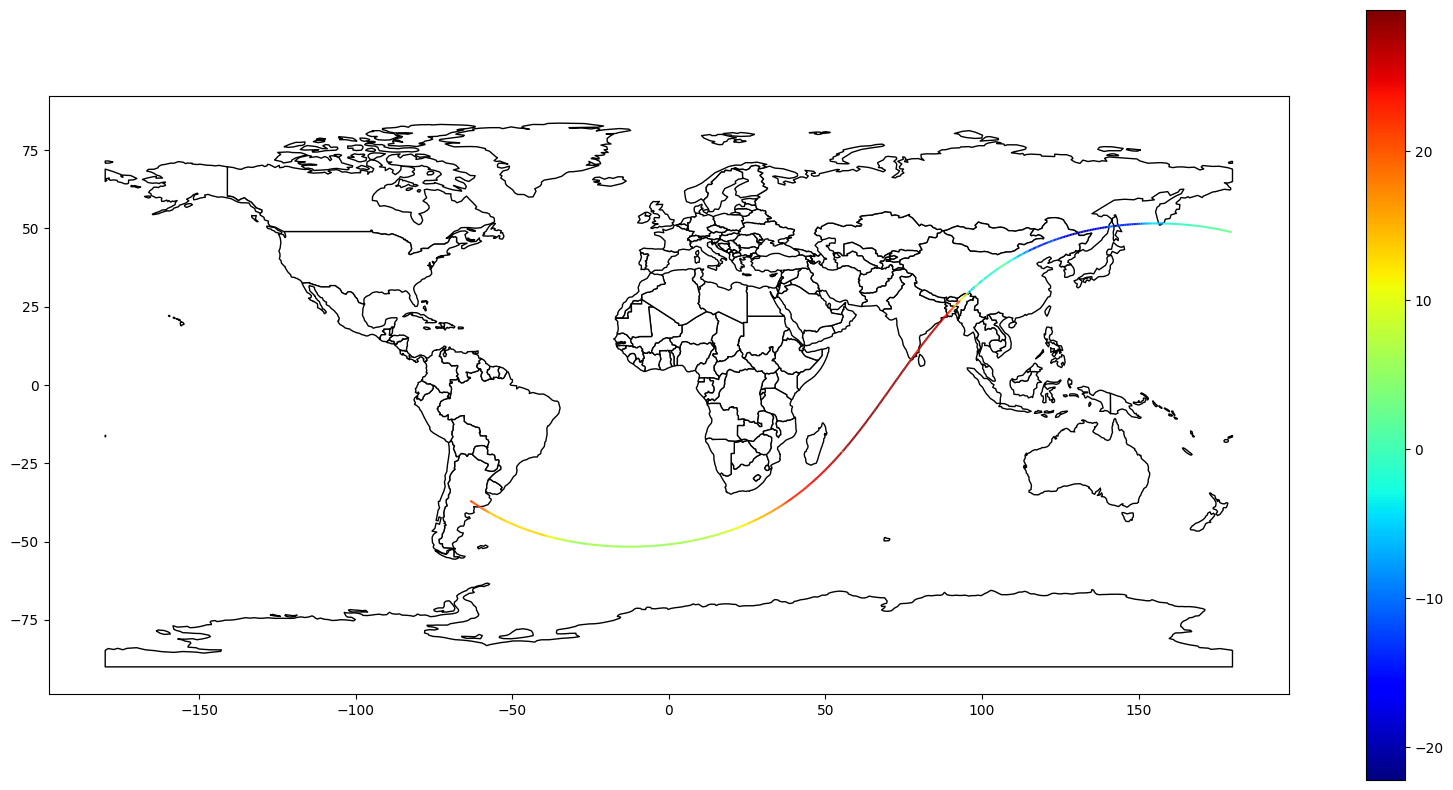

In [43]:
fig, ax = plt.subplots(1, figsize=(20,10))
base = gdf_world.plot(ax=ax, color='white', edgecolor='black',)
iss_trajc.trajectories[0].plot(ax=base, legend="true", column="temperature", cmap='jet')

<Axes: >

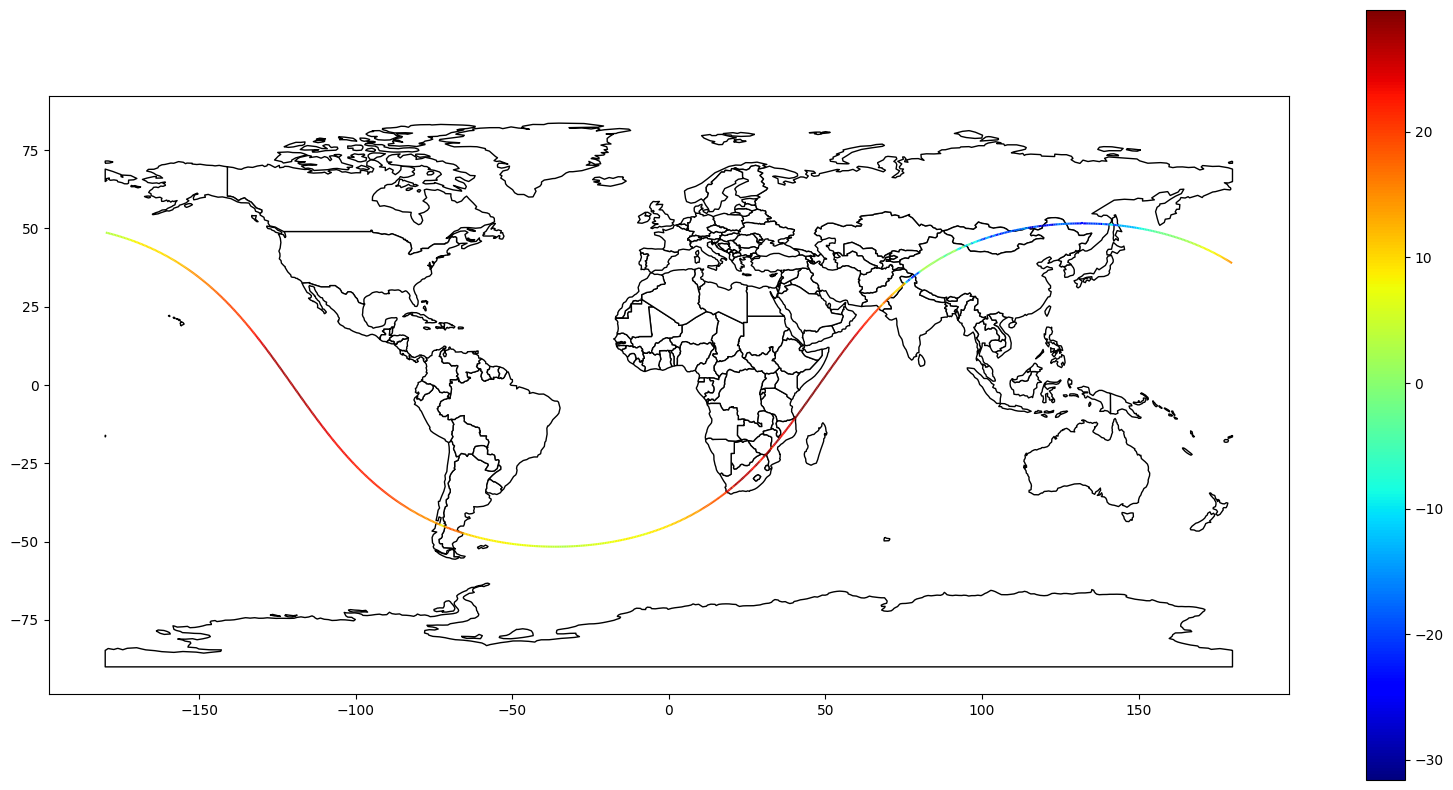

In [44]:
fig, ax = plt.subplots(1, figsize=(20,10))
base = gdf_world.plot(ax=ax, color='white', edgecolor='black',)
iss_trajc.trajectories[1].plot(ax=base, legend="true", column="temperature", cmap='jet')

<Axes: >

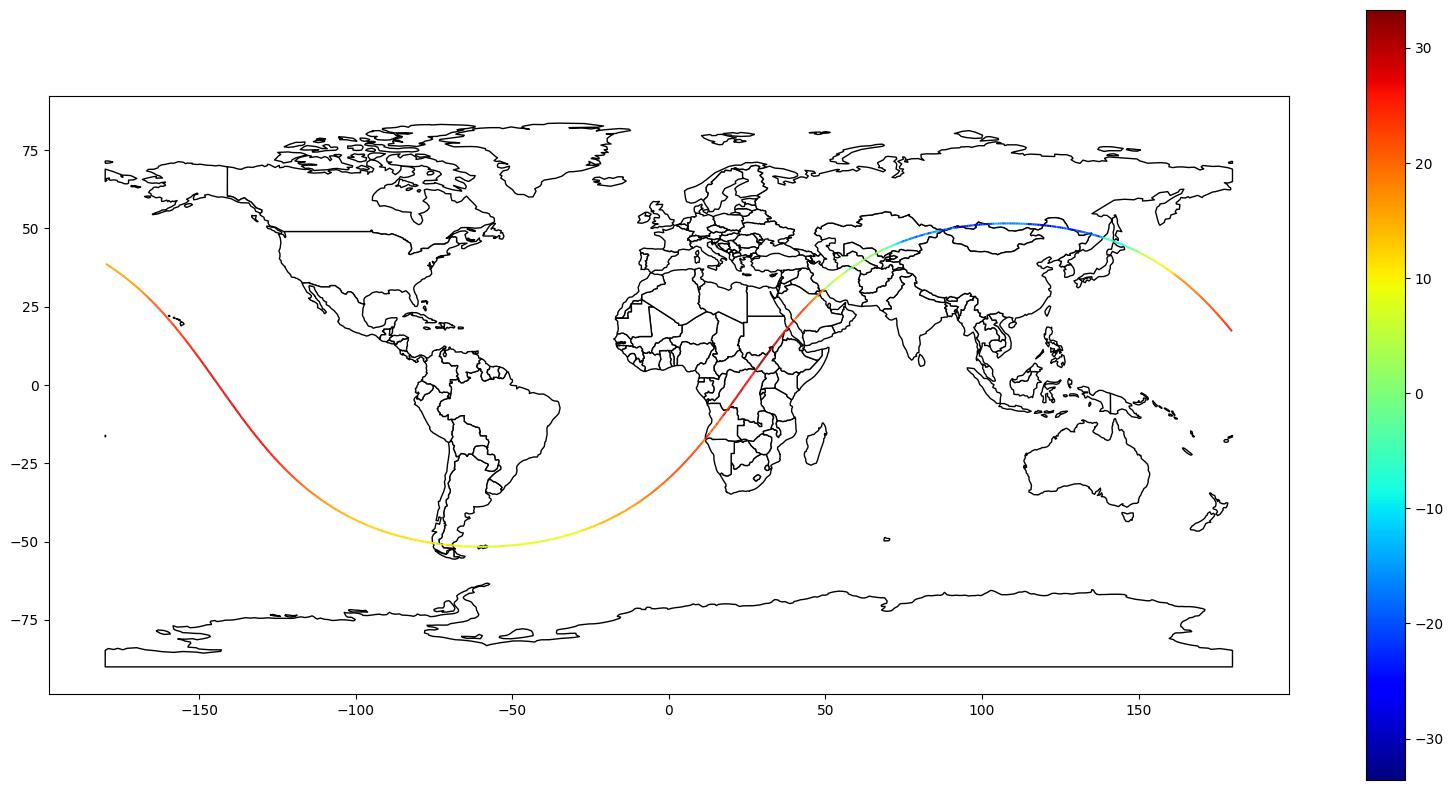

In [45]:
fig, ax = plt.subplots(1, figsize=(20,10))
base = gdf_world.plot(ax=ax, color='white', edgecolor='black',)
iss_trajc.trajectories[2].plot(ax=base, legend="true", column="temperature", cmap='jet')

#### Create interactive plots with weather data

In [46]:
iss_trajc.trajectories[1].hvplot(c="windspeed",
                                 tiles="ESRI",
                                 cmap="jet")

/usr/local/lib/python3.10/dist-packages/holoviews/core/util.py:1585: PanelDeprecationWarning: 'param_value_if_widget' is deprecated and will be removed in version 1.5, use 'transform_reference' instead.
  value = param_value_if_widget(value)
Exception ignored in: functools.partial(<function cleanup_custom_options at 0x78ead1e54280>, 2)
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/holoviews/core/options.py", line 80, in cleanup_custom_options
    raise Exception(
Exception: Cleanup of custom options tree with id '2' failed with the following exception: list.remove(x): x not in list, an unreferenced orphan tree may persist in memory.
/usr/local/lib/python3.10/dist-packages/holoviews/core/util.py:1585: PanelDeprecationWarning: 'param_value_if_widget' is deprecated and will be removed in version 1.5, use 'transform_reference' instead.
  value = param_value_if_widget(value)


:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Path.I   :Path   [Longitude,Latitude]   (windspeed)
   .Points.I :Points   [Longitude,Latitude]   (windspeed,triangle_angle)

In [47]:
iss_trajc.trajectories[1].hvplot(x='easting', y='northing',
                                 c="temperature",
                                 hover_cols=['country', 'windspeed'],
                                 tiles="ESRI",
                                 cmap="Set1")

/usr/local/lib/python3.10/dist-packages/holoviews/core/util.py:1585: PanelDeprecationWarning: 'param_value_if_widget' is deprecated and will be removed in version 1.5, use 'transform_reference' instead.
  value = param_value_if_widget(value)
/usr/local/lib/python3.10/dist-packages/holoviews/core/util.py:1585: PanelDeprecationWarning: 'param_value_if_widget' is deprecated and will be removed in version 1.5, use 'transform_reference' instead.
  value = param_value_if_widget(value)


:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Path.I   :Path   [easting,northing]   (temperature,country,windspeed)
   .Points.I :Points   [easting,northing]   (temperature,triangle_angle,country,windspeed)

In [48]:
my_traj = iss_trajc.trajectories[1]
country = my_traj.df[my_traj.df.land_flag==True].hvplot(c="windspeed", tiles=True, global_extent=True, cmap="jet")
nocountry = my_traj.df[my_traj.df.land_flag==False].hvplot(tiles=True, global_extent=True, color="yellow")
nocountry*country
nocountry

/usr/local/lib/python3.10/dist-packages/holoviews/core/util.py:1585: PanelDeprecationWarning: 'param_value_if_widget' is deprecated and will be removed in version 1.5, use 'transform_reference' instead.
  value = param_value_if_widget(value)


:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Points.I :Points   [Longitude,Latitude]

In [49]:
gdf_path2 = gpd.GeoDataFrame(df[df.land_flag==True], crs={'init': 'epsg:4326'})
iss_trajc2 = mpd.TrajectoryCollection(gdf_path2,
                                 x = "longitude", y="latitude",
                                 traj_id_col="traj_id", t="t")

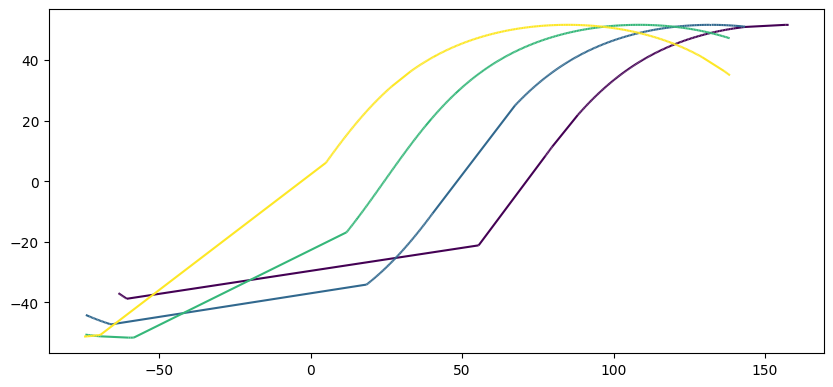

In [50]:
iss_trajc2.plot(column='traj_id', figsize=(10,20));